In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from ijson import items
import configparser

config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

In [2]:
def split_name_list(row, new_df):

    image_id = row.image_id
    object_id = row.object_id
    name_list = row.object_name
    attribute = row.color
    bb_h = row.bb_h
    bb_w = row.bb_w
    bb_x = row.bb_x
    bb_y = row.bb_y

    for name in name_list:
        #print (image_id, object_id, name, attribute)
        new_df.append({
            'image_id':image_id,
            'object_id':object_id,
            'object_name':name.lower(),
            'color':attribute.lower(),
            'bb_h':bb_h,
            'bb_w':bb_w,
            'bb_x':bb_x,
            'bb_y':bb_y
        })# , ignore_index=True)

def no_color_in_name(name, color_list):
    if any(color in name for color in color_list):
        return False
    else:
        return True

## Farbwörter: Berlin & Kay 1969

In [3]:
basic_colors = "red yellow green blue black white gray orange brown pink purple".split()
# vgl. Berlin & Kay 1969

## Import der Objekte 
- alle Objekte, die ein Attribut aus basic_colors haben
- Farbbezeichnung wird normiert (Kleinbuchstaben)

In [5]:
with open (vg_json+'attributes.json', 'r') as f:
    out = []
    for entry in items(f, 'item'):
#        if len(out) > 100:
#            break
        image_id = entry['image_id']
        for attributes in entry['attributes']:
            out_obj = {}
            object_id = attributes.get('object_id', None)
            object_name = attributes.get('names', None)
            w = attributes.get('w',None)
            h = attributes.get('h',None)
            x = attributes.get('x',None)
            y = attributes.get('y',None)
            if attributes.get('attributes', None) != None: 
                for attribute in attributes['attributes']:
                    if attribute.lower() in basic_colors:
                        out_obj = {
                            'image_id': image_id,
                            'object_id': object_id,
                            'object_name': object_name,
                            'color': attribute.lower(),
                            'bb_w': w,
                            'bb_h': h,
                            'bb_x': x,
                            'bb_y': y
                            }
                if len(out_obj) != 0:
                    out.append(out_obj)
                        
color_attributes = pd.DataFrame.from_dict(out)
export = color_attributes.to_csv(vg_json_export+"raw_objects_basic_color_terms.csv")

color_attributes.head()

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id      object_name
0   339    79   421    91   green         1    1058498          [clock]
1   182    88   118    13   black         1    1058507           [sign]
2   101    59   241   289  orange         1    1058511          [shirt]
3   174    91   708   342   white         1    1058515            [car]
4   143    32   574   327  orange         1    1058519  [parking meter]

In [4]:
from sklearn.model_selection import train_test_split
test_ratio = 0.2
dev_ratio = 0.1

n_entries = len(color_attributes)

test_size = int(n_entries * test_ratio)
dev_size = int(n_entries * dev_ratio)
train_size = n_entries - (test_size + dev_size)

train, test = train_test_split(color_attributes, test_size = test_size, shuffle=True, random_state=123)
train, dev = train_test_split(train, test_size = dev_size, shuffle=True, random_state=123)

NameError: name 'color_attributes' is not defined

In [ ]:
print (
    len(train),
    len(test),
    len(dev)
)

print (
    len(train) == train_size,
    len(test) == test_size,
    len(dev) == dev_size
)

In [5]:
color_attributes = pd.read_csv(vg_json_export+"raw_objects_basic_color_terms.csv", index_col=0)
color_attributes['object_name'] = color_attributes.apply(lambda x:eval(x.object_name), axis=1)

In [6]:
objects = color_attributes.copy()

In [10]:
objects_entries = []
objects.apply(lambda x:split_name_list(x, objects_entries),axis=1)
objects = pd.DataFrame.from_dict(objects_entries)

In [14]:
objects = objects[objects.object_name.map(lambda x: no_color_in_name(x,basic_colors))]

In [15]:
objects.shape

(879183, 8)

In [16]:
objects = pd.read_csv(vg_json_export+"objects_basic_color_terms.csv", index_col=0)

In [18]:
objects.head()

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id    object_name
0   339    79   421    91   green         1    1058498          clock
1   182    88   118    13   black         1    1058507           sign
2   101    59   241   289  orange         1    1058511          shirt
3   174    91   708   342   white         1    1058515            car
4   143    32   574   327  orange         1    1058519  parking meter

## Entrophie berechnen

In [109]:
from scipy.stats import entropy

def split_name_list(row, new_df):
    
    image_id = row.image_id
    object_id = row.object_id
    name_list = row.object_name
    attribute = row.color
    
    
    
    for name in name_list:
        #print (image_id, object_id, name, attribute)
        new_df.append({
            'image_id':image_id,
            'object_id':object_id,
            'object_name':name.lower(),
            'color':attribute.lower()
        })# , ignore_index=True)

def no_color_in_name(name, color_list):
    if any(color in name for color in color_list):
        return False
    else:
        return True

def calculate_entropy(row):
    return entropy([row.red, row.yellow, row.green, row.blue, row.black, row.white, row.gray, row.orange, row.brown, row.pink, row.purple])

def plot_object_in_image(row, img_dir):
    
    try:
        image_id = row.image_id
        color = row.color
        object_id = row.object_id
        name = row.object_name
        h = row.bb_h
        w = row.bb_w
        x = row.bb_x
        y = row.bb_y
    except:
        print ('entry missing')
        return
    
    filename = img_dir+str(image_id)+'.jpg'
    
    img = skimage.io.imread(filename)
    
    # Bild plotten
    fig,ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.set_title(color+' '+name)
    
    # BB hinzufügen
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    plt.show()
    
    pass

def plot_from_object_color(obj_name,obj_color,df,imdir=image_dir):
    df[(df['object_name'] == obj_name) & (df['color'] == obj_color)]\
        .apply(lambda x:plot_object_in_image(x,imdir), axis=1)

In [110]:
# neuen DataFrame objects erstellen, in dem Objekte mit mehreren Bezeichnungen
# in mehrere Einträge aufgeteilt werden

objects = pd.DataFrame(columns='image_id color object_id object_name'.split())
objects_entries = []
color_attributes.apply(lambda x:split_name_list(x, objects_entries),axis=1)
objects = pd.DataFrame.from_dict(objects_entries)

#objects.head()

In [111]:
# Objekte mit weniger als 100 Instanzen aussortieren
min_count = 100

frequent_objects = objects.groupby('object_name').size().reset_index(name='count')
print ('Anzahl aller Objekttypen:',len(list(frequent_objects.object_name)))
frequent_objects = frequent_objects.loc[frequent_objects['count'] >= min_count]
frequent_objects = list(frequent_objects.object_name)

print ('Anzahl Objekttypen mit mindestens',min_count,'Instanzen:',len(frequent_objects))

Anzahl aller Objekttypen: 31361
Anzahl Objekttypen mit mindestens 100 Instanzen: 842


In [112]:
# Reshape: Objekte als Index, verschiedene Werte von color aufschlüsseln und pro Objekt aggregieren

colors_per_object = objects\
    .drop(['image_id', 'object_id'], axis=1)\
    .pivot_table(index='object_name',
               columns='color',
               aggfunc=len,
               fill_value=0)

# Objekte aussortieren, die nicht in der Liste frequenter Objekte sind oder Farbwörter im Namen enthalten

colors_per_object = colors_per_object[colors_per_object.index.isin(frequent_objects)]
colors_per_object = colors_per_object[colors_per_object.index.map(lambda x: no_color_in_name(x,basic_colors)).values]
#colors_per_object.head()

In [113]:
# Entropie berechnen
colors_per_object['entropy'] = colors_per_object.apply(lambda x:calculate_entropy(x), axis=1)
#colors_per_object.sort_values('entropy').head()

In [114]:
no_objects = 60
low_entropy_objects = colors_per_object\
                        .sort_values('entropy')\
                        .index.values\
                        [:no_objects]
low_entropy_objects

array(['spinach', 'pickle', 'pea', 'pine tree', 'tusks', 'toilet paper',
       'snow', 'cucumber', 'hedge', 'wiper', 'pepperoni', 'home plate',
       'broccoli', 'foam', 'burner', 'clouds', 'whisker', 'cloud',
       'strawberry', 'tusk', 'lawn', 'whiskers', 'shrub', 'tire',
       'urinal', 'lemon', 'toilet bowl', 'tomato', 'sink', 'forest',
       'tissue', 'carrots', 'teeth', 'tomatoes', 'jeans', 'shrubs',
       'tail light', 'mustard', 'toilet', 'lettuce', 'pasture', 'stems',
       'vegetation', 'light switch', 'foliage', 'pumpkin', 'bushes',
       'carrot', 'jean', 'radiator', 'palm tree', 'papers', 'moss',
       'bush', 'tires', 'bathtub', 'outlet', 'trees', 'wii remote',
       'plant'], dtype=object)

In [10]:
objects = pd.read_csv(vg_json_export+"objects_basic_color_terms.csv", index_col=0)

In [11]:
sample = pd.read_csv(vg_json_export+"objects_basic_color_terms.csv", index_col=0).sample(1000).index

In [15]:
objects.loc[sample].shape

(1000, 8)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from ijson import items
import configparser
from sklearn.model_selection import train_test_split
import sys

sys.path.append(os.path.abspath('../Module'))
import preprocessing

config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

export_dir = vg_json_export + 'extracted_data/'

test_ratio = 0.2
dev_ratio = 0.1
train_ratio = 1 - (test_ratio + dev_ratio)

def split_name_list(row, new_df):

    image_id = row.image_id
    object_id = row.object_id
    name_list = row.object_name
    attribute = row.color
    bb_h = row.bb_h
    bb_w = row.bb_w
    bb_x = row.bb_x
    bb_y = row.bb_y

    for name in name_list:
        #print (image_id, object_id, name, attribute)
        new_df.append({
            'image_id':image_id,
            'object_id':object_id,
            'object_name':name.lower(),
            'color':attribute.lower(),
            'bb_h':bb_h,
            'bb_w':bb_w,
            'bb_x':bb_x,
            'bb_y':bb_y
        })# , ignore_index=True)

# Grundfarben vgl. Berlin & Kay 1969
basic_colors = preprocessing.basic_colors()

if __name__ == "__main__":
    print ('Objekte mit Farbattribut extrahieren')
    with open (vg_json+'attributes.json', 'r') as f:
        # Import der Objekte
        # -> alle Objekte, die ein Attribut aus basic_colors haben
        # -> Farbbezeichnung wird normiert (durch lower() )
        out = []
        for entry in items(f, 'item'):
    #        if len(out) > 100:
    #            break
            image_id = entry['image_id']
            for attributes in entry['attributes']:
                out_obj = {}
                object_id = attributes.get('object_id', None)
                object_name = attributes.get('names', None)
                w = attributes.get('w',None)
                h = attributes.get('h',None)
                x = attributes.get('x',None)
                y = attributes.get('y',None)
                if attributes.get('attributes', None) != None:
                    for attribute in attributes['attributes']:
                        if attribute.lower() in basic_colors:
                            out_obj = {
                                'image_id': image_id,
                                'object_id': object_id,
                                'object_name': object_name,
                                'color': attribute.lower(),
                                'bb_w': w,
                                'bb_h': h,
                                'bb_x': x,
                                'bb_y': y
                                }
                    if len(out_obj) != 0:
                        out.append(out_obj)

    # als DataFrame speichern
    objects = pd.DataFrame.from_dict(out)
    print ("DataFrame Shape:",objects.shape)

    # Einträge teilen, falls mehrere Bezeichnungen für ein Objekt
    print ("Einträge teilen, falls mehrere Bezeichnungen für ein Objekt")
    objects_entries = []
    objects.apply(lambda x:split_name_list(x, objects_entries),axis=1)
    objects = pd.DataFrame.from_dict(objects_entries)
    print ("DataFrame Shape:",objects.shape)

    # Eintrag löschen, falls Farbbezeichnung in Objektname
    print ("Einträge löschen, falls Farbbezeichnung im Objektname")
    objects = objects[objects.object_name.map(lambda x: preprocessing.no_color_in_name(x,basic_colors))]
    print ("DataFrame Shape:",objects.shape)

Objekte mit Farbattribut extrahieren
DataFrame Shape: (887874, 8)
Einträge teilen, falls mehrere Bezeichnungen für ein Objekt
DataFrame Shape: (919431, 8)
Einträge löschen, falls Farbbezeichnung im Objektname
DataFrame Shape: (879183, 8)


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from ijson import items
import configparser
from sklearn.model_selection import train_test_split
import sys

sys.path.append(os.path.abspath('../Module'))
import preprocessing

config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

export_dir = vg_json_export + 'extracted_data/'

test_ratio = 0.2
dev_ratio = 0.1
train_ratio = 1 - (test_ratio + dev_ratio)

def split_name_list(row, new_df):

    image_id = row.image_id
    object_id = row.object_id
    name_list = row.object_name
    attribute = row.color
    bb_h = row.bb_h
    bb_w = row.bb_w
    bb_x = row.bb_x
    bb_y = row.bb_y

    for name in name_list:
        #print (image_id, object_id, name, attribute)
        new_df.append({
            'image_id':image_id,
            'object_id':object_id,
            'object_name':name.lower(),
            'color':attribute.lower(),
            'bb_h':bb_h,
            'bb_w':bb_w,
            'bb_x':bb_x,
            'bb_y':bb_y
        })# , ignore_index=True)

# Grundfarben vgl. Berlin & Kay 1969
basic_colors = preprocessing.basic_colors()

if __name__ == "__main__":
    print ('Objekte mit Farbattribut extrahieren')
    with open (vg_json+'attributes.json', 'r') as f:
        # Import der Objekte
        # -> alle Objekte, die ein Attribut aus basic_colors haben
        # -> Farbbezeichnung wird normiert (durch lower() )
        out = []
        for entry in items(f, 'item'):
    #        if len(out) > 100:
    #            break
            image_id = entry['image_id']
            for attributes in entry['attributes']:
                out_obj = {}
                object_id = attributes.get('object_id', None)
                object_name = attributes.get('names', None)
                w = attributes.get('w',None)
                h = attributes.get('h',None)
                x = attributes.get('x',None)
                y = attributes.get('y',None)
                if attributes.get('attributes', None) != None:
                    for attribute in attributes['attributes']:
                        if attribute.lower() in basic_colors:
                            out_obj = {
                                'image_id': image_id,
                                'object_id': object_id,
                                'object_name': object_name,
                                'color': attribute.lower(),
                                'bb_w': w,
                                'bb_h': h,
                                'bb_x': x,
                                'bb_y': y
                                }
                            out.append(out_obj)
                            out_obj = {}

    # als DataFrame speichern
    objects2 = pd.DataFrame.from_dict(out)
    print ("DataFrame Shape:",objects2.shape)

    # Einträge teilen, falls mehrere Bezeichnungen für ein Objekt
    print ("Einträge teilen, falls mehrere Bezeichnungen für ein Objekt")
    objects_entries = []
    objects2.apply(lambda x:split_name_list(x, objects_entries),axis=1)
    objects2 = pd.DataFrame.from_dict(objects_entries)
    print ("DataFrame Shape:",objects2.shape)

    # Eintrag löschen, falls Farbbezeichnung in Objektname
    print ("Einträge löschen, falls Farbbezeichnung im Objektname")
    objects2 = objects2[objects2.object_name.map(lambda x: preprocessing.no_color_in_name(x,basic_colors))]
    print ("DataFrame Shape:",objects2.shape)

Objekte mit Farbattribut extrahieren
DataFrame Shape: (992507, 8)
Einträge teilen, falls mehrere Bezeichnungen für ein Objekt
DataFrame Shape: (1030919, 8)
Einträge löschen, falls Farbbezeichnung im Objektname
DataFrame Shape: (989371, 8)


In [49]:
colors_per_object = objects2.groupby(['object_id', 'color']).size().reset_index(name='count')\
    .groupby(['object_id']).size().reset_index(name='count')\
    .sort_values(by='count', ascending=False)
multiple_color_ids = colors_per_object.loc[colors_per_object['count'] > 1].object_id.values

print (objects2.shape[0])

print (objects2.loc[np.logical_not(
    objects2['object_id'].isin(multiple_color_ids)
)].shape[0])

989371
780557


# Test: CBOs

In [10]:
import sys
sys.path.append(os.path.abspath('../Module'))
import preprocessing

freq_obj,cd_obj,cb_obj,cn_obj = preprocessing.freq_cdo_cno(objects)
# Objektnamen als Id, one hot encdoing für Farben
colors_per_object = objects\
    .drop(['image_id', 'object_id', 'bb_x', 'bb_y', 'bb_w', 'bb_h'], axis=1)\
    .pivot_table(index='object_name',
               columns='color',
               aggfunc=len,
               fill_value=0)

# Aussortieren: Nur noch frequente Objekte ohne Farbe im Namen
colors_per_object = colors_per_object[colors_per_object.index.isin(freq_obj)]
colors_per_object = colors_per_object[colors_per_object.index.map(lambda x: preprocessing.no_color_in_name(x,preprocessing.basic_colors())).values]

# Entropie berechnen
colors_per_object['entropy'] = colors_per_object.apply(lambda x:preprocessing.calculate_entropy(x), axis=1)

TypeError: unhashable type: 'list'

In [118]:
size = 100
mddl = round(len(colors_per_object)/2)
cbos = objects2.loc[objects2['object_name'].isin(
    colors_per_object.sort_values('entropy').iloc[int(mddl-(size/2)):int(mddl+(size/2))].index.to_list()
)]
cdos = objects2.loc[objects2['object_name'].isin(cd_obj.keys())]
cnos = objects2.loc[objects2['object_name'].isin(cn_obj)]

In [121]:
colors_per_object.sort_values('entropy').iloc[int(mddl-(size/2)):int(mddl+(size/2))]

color           black  blue  brown  gray  green  orange  pink  purple  red  \
object_name                                                                  
ears              186     1    153    16      2      16    44       0    4   
shelves            15     6     19     2      5       1     0       0    3   
table             635   211   2475   126    183      48    25      21  259   
cat              1574     9    661   431     12     502     9       2   15   
glove            1625   165    368    67     50      36    45      21  187   
curb               22     8      6    51      4       5     0       0  163   
lettering         473   148      4    12     53      37     8      14  279   
chimney            21     2     25    11      7       2     0       0   89   
ship               30    38      6     4      6       8     0       0   32   
parking meter      76     5      1    35     17       6     0       0    4   
suit              785   144     42    99     35      23    22      15  119   
rocks              73     4    178   219      7       5     3       0   25   
picture           313    50     54     5     28      13     6       3   49   
eye              1942   418    671    14    413      63     3       7  114   
shower curtain     17    21      9     3      6       5     7       2    4   
windows           139    35      9     8     35       2     0       1   18   
bow tie            64    12      1     0      3       2     7       4   32   
markings           45    15     16     5      5       5     1       1   24   
ear               647     6    612   138      3      42   195       1   23   
soccer ball        60    42      0     1     11       3     4       1   36   
birds              87    12     19    10     13       2     1       0    8   
letters           759   278     21    23    110      75    19      17  493   
menu               18     6      4     0      9       0     0       3   20   
tarp               44   217      9    16    113       7     1       2   18   
signboard          16    11      0     0     12       2     0       0   26   
surfboard         187   598     56    18    151     127    60      19  327   
rack               79     8     19     8      9       1     2       2    6   
boot              610    39    192    25     20      22    20       3  109   
boat              222   704    154    37    155      89     9       2  507   
shoes            2047   282    371   121     83      76    97      27  332   
...               ...   ...    ...   ...    ...     ...   ...     ...  ...   
grip               38    22      1     1      2       3     2       5   10   
locomotive         50    11      0     3      8       2     0       0   27   
tile              363   241    436   141    162      35    98       1  244   
court               8   336     84    34    499      43     3      37  130   
rose                2     9      8     0      5      24    83       3  155   
cup               138   306     82    10    157      79    46      26  315   
bed                34    70    109     8     19      10    13      13   55   
man               419   156    107    53     48      26    10       8  114   
strap             583    85     80    34     33      24    21      16   80   
buildings          11    19     72    10      5       9     5       0   39   
stone              50    14     81   163      4       4     1       0   25   
uniform           240   298      6   113     61      45     2       7  256   
cooler              8    81      0     4     20      58     6       3   86   
frosting            8    54     36     0     44      26    91       7   36   
brick wall          3     4     17     2      5       1     1       3   48   
trailer            15    30      4     7     15       5     0       0   29   
helmet           2868   958     25   166    202     118    80      59  915   
onions              0     0     10     0     39       2     6      28   56   
flooring           12 

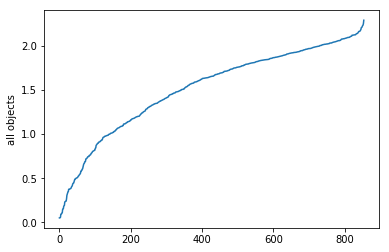

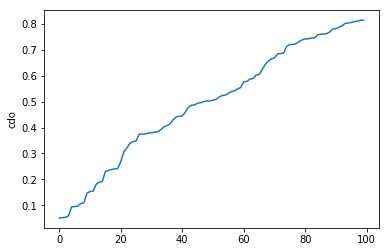

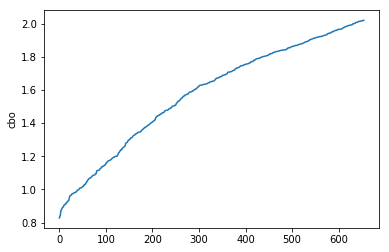

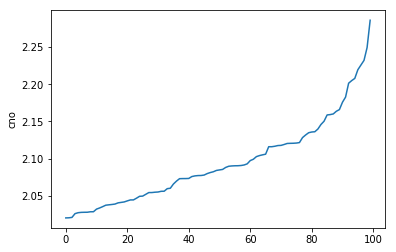

In [87]:
import matplotlib.pyplot as plt
# all
plt.plot(colors_per_object.sort_values('entropy').entropy.values)
plt.ylabel('all objects')
plt.show()
 # cdo
plt.plot(colors_per_object.sort_values('entropy').entropy.values\
        [:100]\
        )
plt.ylabel('cdo')
plt.show()
 # cbo
plt.plot(colors_per_object.sort_values('entropy').entropy.values\
        [100:-100]\
        )
plt.ylabel('cbo')
plt.show()
 # cno
plt.plot(colors_per_object.sort_values('entropy').entropy.values\
        [-100:]\
        )
plt.ylabel('cno')
plt.show()